In [2]:
import os
import torch
import pickle
from skimage import io
import matplotlib.pyplot as plt
from torchvision.models import resnet152
from torch.utils.data import DataLoader
from albumentations.pytorch import ToTensorV2
from albumentations import Compose, Normalize, Resize, Rotate, HorizontalFlip, RandomCrop
from dataset import CustomDataset
from model import DepthEstimationNet, ModifiedBlock
from training import train_model, DBELoss, get_training_augmentation, get_validation_augmentation, setup_logging
from fourier_analysis import FDC
from torch import optim
import numpy as np
from torchvision.transforms.functional import to_pil_image
from PIL import Image

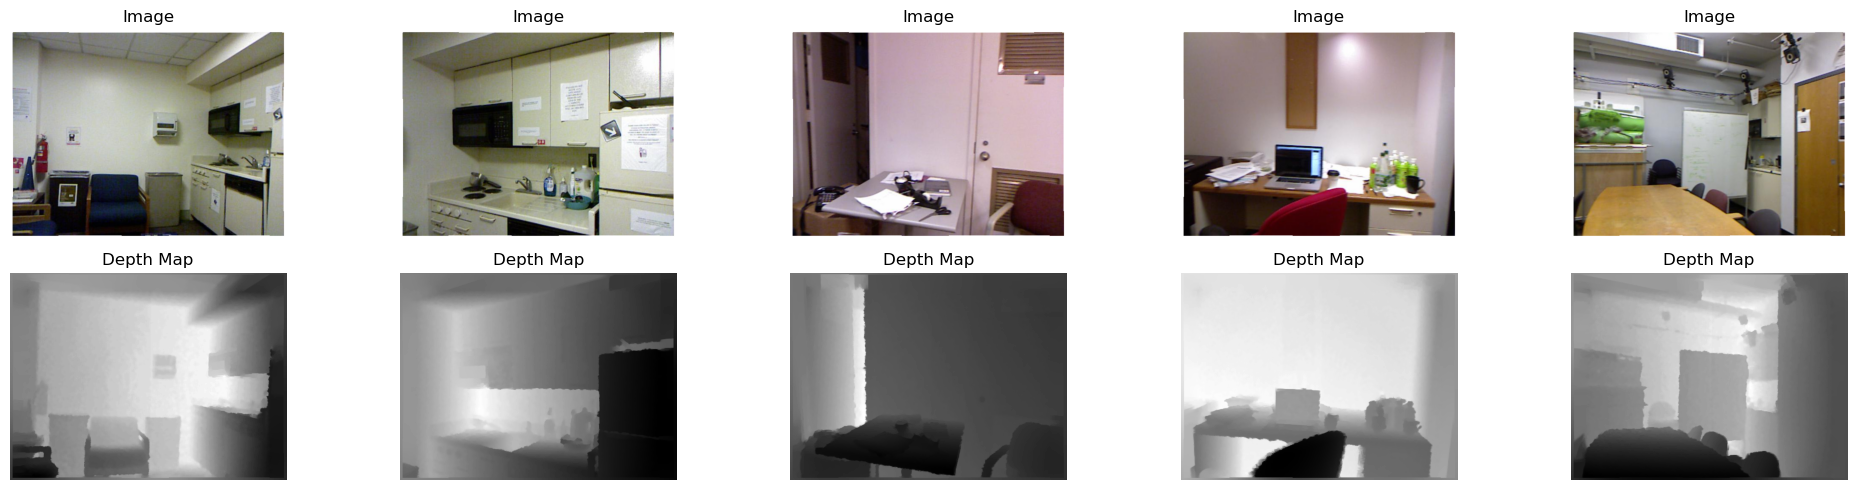

In [3]:
def display_samples(data_dir, num_samples=5):
    images_dir = os.path.join(data_dir, 'images/train')
    depths_dir = os.path.join(data_dir, 'depths/train')
    image_paths = sorted([os.path.join(images_dir, name) for name in os.listdir(images_dir) if name.endswith('.p')])
    depth_paths = sorted([os.path.join(depths_dir, name) for name in os.listdir(depths_dir) if name.endswith('.p')])

    plt.figure(figsize=(20, 5))
    for i in range(num_samples):
        image = pickle.load(open(image_paths[i], 'rb'))
        depth = pickle.load(open(depth_paths[i], 'rb'))
        
        # If images are floats in [0, 255] range, we need to convert to uint8
        image = image.astype('uint8')
        
        # Display image
        plt.subplot(2, num_samples, i + 1)
        plt.imshow(image)
        plt.title('Image')
        plt.axis('off')

        # Display depth map - normalize to [0, 1] range for display purposes
        normalized_depth = (depth - depth.min()) / (depth.max() - depth.min())
        plt.subplot(2, num_samples, i + 1 + num_samples)
        plt.imshow(normalized_depth, cmap='gray')
        plt.title('Depth Map')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

data_dir = './data/nyu_v2'
display_samples(data_dir)


In [5]:
# Set the device with MPS support for Apple Silicon if available
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')

# Set up logging
project_dir = os.getcwd()
save_dir = os.path.join(project_dir, 'models', 'training_runs')
os.makedirs(save_dir, exist_ok=True)
setup_logging(save_dir)

# Initialize model
model = DepthEstimationNet(device=device)

# Define custom transform functions using Albumentations
train_transforms = Compose([
    Rotate(limit=35, p=0.5),
    HorizontalFlip(p=0.5),
    RandomCrop(height=427, width=561, always_apply=True),
    Resize(240, 320),
    Normalize(),
    ToTensorV2(),
])

val_transforms = Compose([
    RandomCrop(height=427, width=561, always_apply=True),
    Resize(240, 320),
    Normalize(),
    ToTensorV2(),
])

data_dir = './data/nyu_v2'
images_train_dir = os.path.join(data_dir, 'images', 'train')
depths_train_dir = os.path.join(data_dir, 'depths', 'train')
images_val_dir = os.path.join(data_dir, 'images', 'val')
depths_val_dir = os.path.join(data_dir, 'depths', 'val')

train_dataset = CustomDataset(images_train_dir, depths_train_dir, transform=train_transforms)
val_dataset = CustomDataset(images_val_dir, depths_val_dir, transform=val_transforms)


# Prepare dataloaders
dataloaders = {
    'train': DataLoader(train_dataset, batch_size=4, shuffle=True),
    'val': DataLoader(val_dataset, batch_size=4)
}

# Loss function, optimizer, and scheduler
criterion = DBELoss(device=device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

# Train the model
#trained_model = train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=50, save_dir=save_dir)

#We saved the trained model in the previous step. The model is about 31gb so we decided not to include it in the final submission
torch.save(trained_model.state_dict(), 'models/trained_model.pth')


In [7]:
# Load the trained model
model = DepthEstimationNet(device=device)
model.load_state_dict(torch.load('models/trained_model.pth'))
model.eval()

# Here we can see the output which is the model's architecture and the number of parameters that we modified




DepthEstimationNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0):

(-0.5, 561.5, 431.5, -0.5)

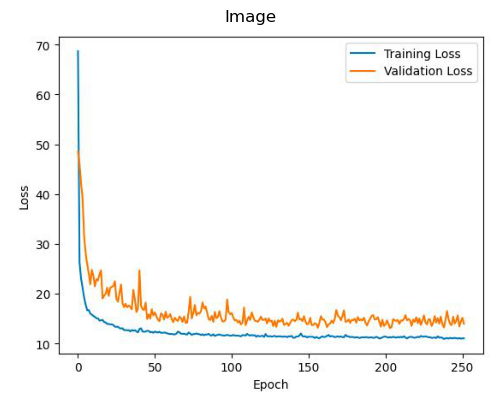

In [11]:
#We are going to plot the training and validation loss of our trainig
training_loss = np.load('./models/train_loss.pkl',allow_pickle=True)
validation_loss = np.load('./models/val_loss.pkl',allow_pickle=True)
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


(-0.5, 832.5, 469.5, -0.5)

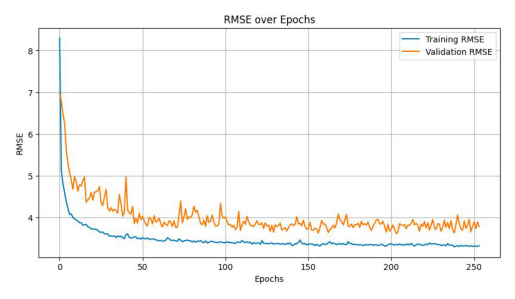

In [17]:
import re

log_file_path = 'models/training.log'

# Regular expressions to match the necessary data
training_pattern = r'Training:.*RMSE: (\d+\.\d+)'
validation_pattern = r'Validation:.*RMSE: (\d+\.\d+)'

# Lists to store the extracted RMSE values
training_rmses = []
validation_rmses = []

# Read the file and extract RMSE values
with open(log_file_path, 'r') as file:
    lines = file.readlines()
    for line in lines:
        training_match = re.search(training_pattern, line)
        validation_match = re.search(validation_pattern, line)

        if training_match:
            training_rmses.append(float(training_match.group(1)))
        if validation_match:
            validation_rmses.append(float(validation_match.group(1)))

# Plotting the RMSE values
plt.figure(figsize=(10, 5))
plt.plot(training_rmses, label='Training RMSE')
plt.plot(validation_rmses, label='Validation RMSE')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.title('RMSE over Epochs')
plt.legend()
plt.grid(True)
plt.show()



In [18]:
#Arguments:
data_path = '../data/nyu_v2/'
batch_size = 16
depth_size = (25, 32)
test_crop = (427, 561)
seed = 2
torch.manual_seed(seed)
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')

In [2]:
sample = next(iter(dataloaders['train']))
depth = sample['depth']
Prediction = model(sample['image'].to(device).float())

#Pick one image from the batch


In [ ]:
#Now we define the Fourier Domain Classification (FDC) model
#We are going to use the model that we trained in the previous steps as the base model for the FDC model

fdc_model = FDC(model=model)  # Initialize the FDC model

In [ ]:
#This is the model forward method that we are going to use to get the Fourier transform of the data
try:
    f_m_hat, f = fdc_model.forward(dataloaders)
    print("Fourier transform data shapes:", f_m_hat.shape, f.shape)
except Exception as e:
    print(f"Error in forward execution: {e}")

#f_m_hat is the DFT vector of the mth Depth map (After crops)
#We use these vectors to train the FDC model to find the optimal weights for the model like explained 
#in the paper
#We trained over 1200 images


Forward phase started
Model set to eval mode
Processing batch 1, Inputs reshaped: torch.Size([1, 36, 3, 224, 224])
Model forward pass complete
Crops merged
2D FFT computed.
Converted complex FFT result to real format: torch.Size([9, 25, 17, 2])
Flattened FFT shape: torch.Size([9, 850])
Hey
2D FFT computed.
Converted complex FFT result to real format: torch.Size([1, 25, 17, 2])
Flattened FFT shape: torch.Size([1, 850])
hEY2
Fourier transform completed for batch 1
Processing batch 2, Inputs reshaped: torch.Size([1, 36, 3, 224, 224])
Model forward pass complete
Crops merged
2D FFT computed.
Converted complex FFT result to real format: torch.Size([9, 25, 17, 2])
Flattened FFT shape: torch.Size([9, 850])
Hey
2D FFT computed.
Converted complex FFT result to real format: torch.Size([1, 25, 17, 2])
Flattened FFT shape: torch.Size([1, 850])
hEY2
Fourier transform completed for batch 2
Processing batch 3, Inputs reshaped: torch.Size([1, 36, 3, 224, 224])
Model forward pass complete
Crops merged


In [ ]:
fdc_model.fit(f_m_hat, f)
#Here we fit the model with the data that we have obtained from the forward method 
#We estimate the weights and bias of the model
#We used the SVD method to estimate the pseudo-inverse of the matrix and then we used the pseudo-inverse to estimate the weights and bias of the model

Fitting FDC weights...


/Users/Aminekhelif/Documents/originaldepth/DEN/Notebooks/../fdc.py:61: UserWarning: The operator 'aten::linalg_svd' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:11.)
  U, S, V = torch.svd(T_k)


Weights and biases fitted successfully.


In [ ]:
fdc_model.save_weights('./')
#We save the weights of the model in the current directory

Saving FDC wieghts...


In [ ]:
#fdc_model.load_weights('./')
#We optionally load the weights of the model from the current directory


In [25]:
#We are gonna define a function to loop 
def fdc_predict_loop(model, fdc_model, batch):
    predictions = []
    data = batch['stacked_images'].to(device).float()
    for i in range(data.shape[0]):
        with torch.no_grad():
            result = model(data[i])
        candidates = fdc_model.merge_crops(result)
        f_m_hat = fdc_model.img2fourier(candidates)
        f_hat = fdc_model.predict(f_m_hat)
        d_hat = fdc_model.fourier2img(f_hat.view(1, -1), depth_size)
        predictions.append(d_hat[0])
    
    return predictions

In [26]:
batch_for_den = next(iter(dataloaders['val']))
batch_for_fdc = next(iter(dataloaders['fdc']))

img = batch_for_den['image']
d = batch_for_den['depth']
d_hat_den = model(batch_for_den['image'].to(device).float())
d_hat_fdc = fdc_predict_loop(model, fdc_model, batch_for_fdc)

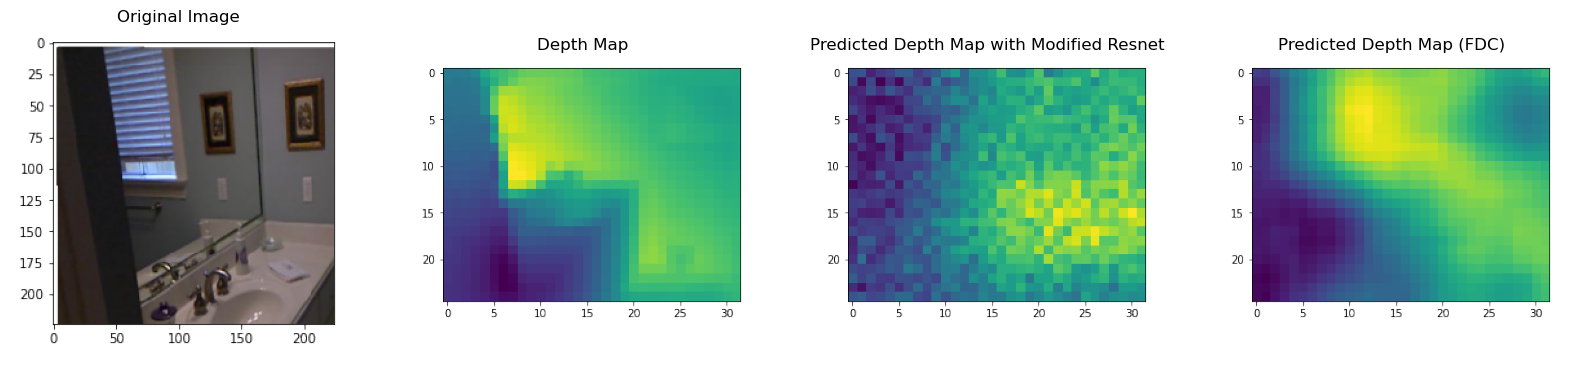

In [24]:
fig, axs = plt.subplots(1, 4, figsize=(20, 5))
original_img = to_pil_image(sample['stacked_images'][0][4].cpu())
axs[0].imshow(original_img)
axs[0].set_title('Original Image')
axs[0].axis('off')
depth_map = sample['depth'][0].cpu().reshape(25, 32)
axs[1].imshow(depth_map, cmap='viridis')
axs[1].set_title('Depth Map')
axs[1].axis('off')
input_data = sample['stacked_images'][0][0].unsqueeze(0).to(device)  # Add batch dimension
with torch.no_grad():
    predicted_depth = model(input_data).cpu().reshape(25, 32)
axs[2].imshow(predicted_depth, cmap='viridis')
axs[2].set_title('Predicted Depth Map with Modified Resnet')
axs[2].axis('off')
fdc_input = sample['stacked_images'][0].to(device).float()
with torch.no_grad():
    fdc_output = fdc_model(fdc_input).cpu().reshape(25, 32)
axs[3].imshow(fdc_output, cmap='viridis')
axs[3].set_title('Predicted Depth Map (FDC)')
axs[3].axis('off')
plt.tight_layout()
plt.show()


# Conclusion and Reflections

## Model Training and Inference
We successfully trained our modified ResNet model, incorporating tailored extraction layers that served as a solid foundation for depth map estimation. By leveraging the strengths of this architecture, we were able to extract vital features and depth-related cues critical for our model's performance.

Building upon this, we integrated Fourier domain analysis, pushing the boundaries of conventional depth estimation techniques. This approach allowed us to analyze and synthesize depth information from a unique perspective, enhancing the model's ability to estimate depth maps with greater accuracy.

## Challenges Encountered
The journey was not without its hurdles. One significant challenge was the initial lack of hardware resources, which constrained our ability to train the model comprehensively. Moreover, the myriad of dependencies and the complexity of configuring our development environment posed substantial barriers to rapid experimentation and iteration.

The complexity of the dataset, as discussed in the accompanying paper, added another layer of difficulty. Many of the images were unlabeled, and others did not translate well into usable data, limiting the breadth of examples we could test and refine our model against.

Despite these challenges, we managed to perform inference and draw comparisons between the estimated depth maps. This endeavor allowed us to not only validate our model's capabilities but also to gain insights into areas of potential improvement for future research and development.

## Forward-Looking Statements
As we conclude, we acknowledge the path ahead is rife with opportunities for enhancement. With better hardware, refined data processing techniques, and continuous model optimization, we are optimistic about overcoming the limitations we've encountered and achieving new heights in depth estimation.

The journey thus far has been a testament to our resilience and commitment to innovation in the face of adversity. We look forward to future advancements in this exciting field.
